# Trabalho Prático - Word Embeddings
## Thiago Pádua de Carvalho - 2020007066

## Introdução
Neste trabalho prático, foi proposta a implementação de modelos de word embeddings e sua posterior avaliação em tarefas de similaridade e analogia de palavras. Para tal, foram criados modelos com variações de arquitetura e hiperparâmetros.
## Hiperparâmetros
Os hiperparâmetros utilizados foram:
- **Embedding Size**: Tamanho do vetor de embedding. Isto é, o número de dimensões do vetor de representação gerado para cada palavra no vocabulário. Por exemplo, para um embedding_size=2, cada palavra é representada por um vetor bidimensional. Como demonstração, [0.5, -0.3].
- **Window Size**: Tamanho da janela de contexto. Esse hiperparâmetro modifica como o cenário ao redor de uma palavra-alvo que será considerado durante o treinamento. Ele especifica quantas palavras à esquerda e à direita da referência o modelo deve se basear aprender suas representações.\
Por exemplo, se window_size=2, o modelo usa as 2 palavras imediatamente antes e as 2 imediatamente depois da palavra-alvo como contexto.
Exemplo: Para a frase "O modelo Word2Vec usa janelas de contexto", com window_size=2, o contexto da palavra "Word2Vec" seria ["O", "modelo", "usa", "janelas"].

- **Epochs**: Número de épocas de treinamento. Ele define a quantidade de vezes que o modelo percorre o corpus de treinamento completo durante o aprendizado, ou seja, quantas iterações sobre os dados serão feitas, afetando a convergência e a qualidade dos embeddings.

## Arquiteturas
Foram implementadas 2 arquiteturas de word embeddings:
- **Skip-gram**: Modelo que prevê as palavras do contexto a partir de uma palavra central.\
1 - Escolhe-se uma janela de contexto de tamanho k\
2 - O modelo é treinado para associar a palavra-alvo wt com cada palavra de contexto wc dentro da janela.\
3 - O objetivo do Skip-gram é maximizar a probabilidade conjunta de todas as palavras de contexto

- **CBOW**: Modelo que prevê a palavra central a partir das palavras do contexto:\
1 - Recebe as palavras de contexto (as palavras ao redor da palavra-alvo) como entrada.\
2 - Calcula a média dos vetores das palavras de contexto.\
3 - Tenta prever a palavra-alvo com base nessa média.

| **Aspecto**                  | **CBOW**                                      | **Skip-gram**                              |
|-------------------------------|-----------------------------------------------|--------------------------------------------|
| **Direção de predição**       | Contexto → Palavra-alvo                      | Palavra-alvo → Contexto                    |
| **Velocidade de treinamento** | Mais rápido                                  | Mais lento                                 |
| **Requisito de dados**        | Funciona bem com corpora pequenos            | Requer corpora maiores                    |
| **Foco semântico**            | Palavras frequentes                         | Palavras raras                            |
| **Robustez**                  | Melhor para contextos mais comuns           | Melhor para capturar relações profundas    |


### Implementação

In [33]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

import ast
import itertools

In [3]:
with open("data/text8", "r") as file:
    corpus = file.read()

# Tokenize the corpus
words = corpus.split()

block_size = 50
sentences = [words[i:i + block_size] for i in range(0, len(words), block_size)]

In [4]:
def evaluate_model(model, analogy_file="data/questions-words.txt"):
    total_distance = 0
    num_analogies = 0

    with open(analogy_file, "r") as file:
        for line in file:
            if line.startswith(":"):  # Ignore categories
                continue

            words = line.strip().split()
            if all(word in model.wv for word in words):  # Check if all words are in the vocabulary
                vector_a = model.wv[words[1]]  # Example: France
                vector_b = model.wv[words[0]]  # Example: Paris
                vector_c = model.wv[words[2]]  # Example: Berlin
                vector_d = model.wv[words[3]]  # Example: Germany

                result_vector = vector_a - vector_b + vector_c

                # Compute the cosine distance between the resulting vector and the expected vector
                distance = cosine(result_vector, vector_d)
                total_distance += distance
                num_analogies += 1

    average_distance = total_distance / num_analogies
    return average_distance


In [5]:
def generate_hyperparams_combinations(hyperparams):
    keys = hyperparams.keys()
    values = hyperparams.values()
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

In [69]:
hyperparams = {
    "embedding_size": [30, 50, 100, 200, 300, 500, 700],
    "window_size": [2, 3, 4, 5, 10],
    "skip_gram": [0, 1],
    "epochs": [5, 10, 15, 30, 40]
}

data_dir = "models"

results = []

# This might take a while
for params in generate_hyperparams_combinations(hyperparams):
    model = Word2Vec(
        sentences=sentences,
        vector_size=params["embedding_size"],
        window=params["window_size"],
        sg=params["skip_gram"],
        epochs=params["epochs"],
        workers=6
    )

    model_name = f"word2vec_{params['embedding_size']}_{params['window_size']}_{params['skip_gram']}_{params['epochs']}.model"
    model.save(f"{data_dir}/{model_name}")

    avg_distance = evaluate_model(model)
    results.append((model_name, avg_distance, params))

In [34]:
# Luckily, I have already run the code and saved the results in a file
results = []
with open("results.txt", "r") as file:
    for line in file:
        parts = line.strip().split(", ")
        dict_str = parts[2:]
        dict_str = ", ".join(dict_str)
        params = ast.literal_eval(dict_str.split(": ", 1)[1])
        model_name = parts[0].split(": ")[1]
        avg_distance = float(parts[1].split(": ")[1])
        results.append((model_name, avg_distance, params))

In [19]:
best_model = min(results, key=lambda x: x[1])
print(f"Best model: {best_model[0]} with average distance: {best_model[1]:.4f}")

Best model: word2vec_30_5_1_5.model with average distance: 0.2724


## Funções Auxiliares

In [20]:
def calculate_average_distances(results, param):
    average_distance_by_param_size_cbow = {}
    average_distance_by_param_size_sg = {}

    for result in results:
        param_size = result[2][param]
        if result[2]["skip_gram"] == 0:
            if param_size not in average_distance_by_param_size_cbow:
                average_distance_by_param_size_cbow[param_size] = []
            average_distance_by_param_size_cbow[param_size].append(result[1])
        else:
            if param_size not in average_distance_by_param_size_sg:
                average_distance_by_param_size_sg[param_size] = []
            average_distance_by_param_size_sg[param_size].append(result[1])

    param_sizes = list(average_distance_by_param_size_cbow.keys())
    cbow_expected = [sum(distances) / len(distances) for distances in average_distance_by_param_size_cbow.values()]
    skipgram_expected = [sum(distances) / len(distances) for distances in average_distance_by_param_size_sg.values()]

    return param_sizes, cbow_expected, skipgram_expected

In [26]:
def plot_param_size_vs_distance(param_sizes, param_name, cbow_expected, skipgram_expected, width=0.5):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 lines and 2 columns

    # CBOW
    axes[0].bar(param_sizes, cbow_expected, color='purple', width=width)
    axes[0].set_title("Distância Cosseno - CBOW")
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel("Valor Esperado (Média das Distâncias Cosseno)")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Skip-gram
    axes[1].bar(param_sizes, skipgram_expected, color='red', width=width)
    axes[1].set_title("Distância Cosseno - Skip-gram")
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel("Valor Esperado (Média das Distâncias Cosseno)")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustar layout e mostrar
    plt.tight_layout()
    plt.show()

## Análise dos resultados
### Influência individual dos hiperparâmetros no valor esperado da distância de cosseno
#### Embedding Size

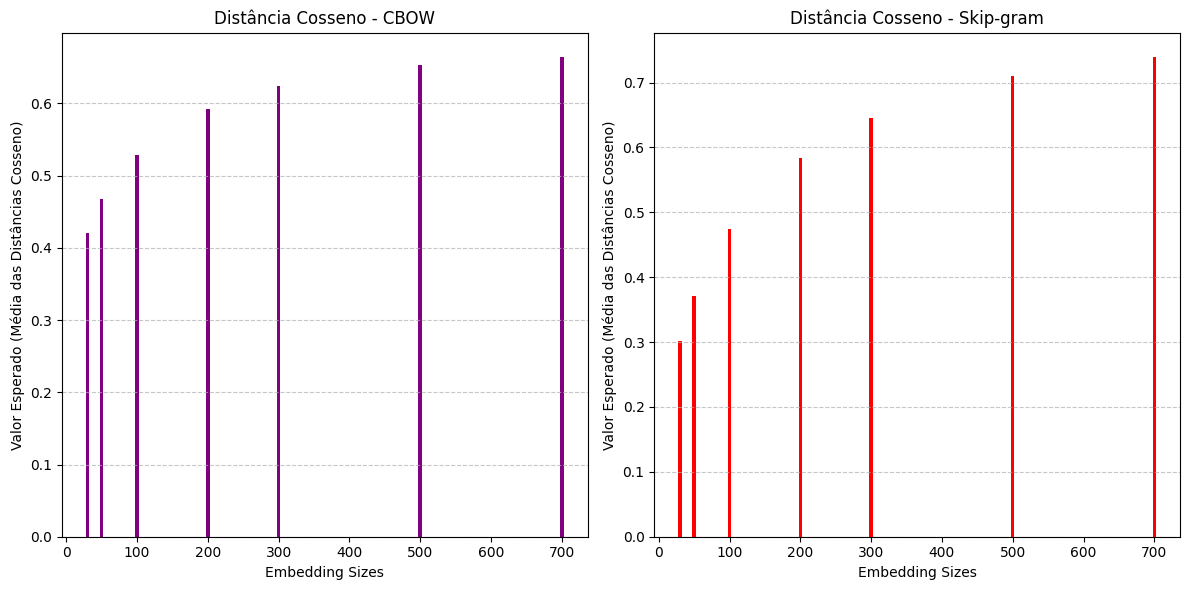

In [39]:
embedding_sizes, cbow_expected, skipgram_expected = calculate_average_distances(results, "embedding_size")
plot_param_size_vs_distance(embedding_sizes, "Embedding Sizes", cbow_expected, skipgram_expected, width=5)

Dentre os hiperparâmetros analisados, o tamanho do vetor de embedding foi o que mais influenciou o valor esperado da distância de cosseno. Foi observada uma relação direta, em que as duas grandezas crescem juntas. Isso pode ser explicado pela maldição da dimensionalidade, que afirma que, os vetores no espaço tendem a ficar mais dispersos e se movem para regiões mais afastadas do espaço conforme o número de dimensões aumenta. Além disso, valores grandes fazem com a distância de cosseno seja uma medida ruidosa, uma vez que há uma maior sensibilidade a pequenas variações.

Outro fator importante é a complexidade. Embeddings maiores conseguem capturar mais detalhes e variações no espaço semântico. No entanto, isso também pode levar a maior variação entre os vetores, especialmente quando os dados não são suficientemente grandes ou ricos para explorar toda a capacidade. Há também a possibilidade de overfitting, visto que o modelo pode começar a "memorizar" padrões específicos dos dados de treinamento, em vez de generalizar bem.

#### Tamanho da janela de contexto

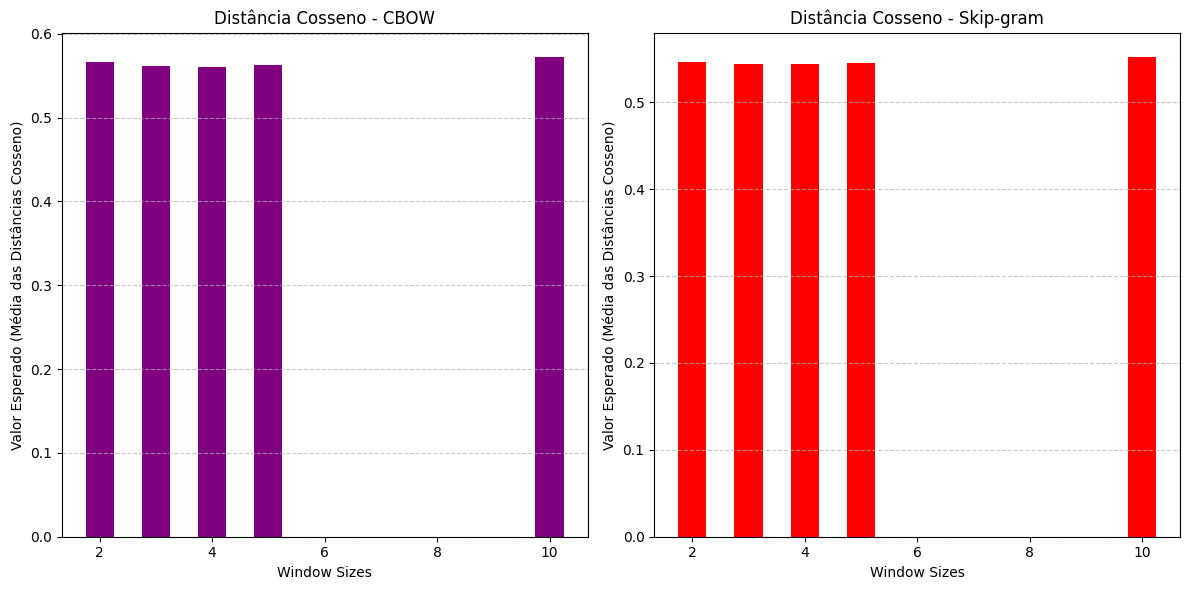

In [40]:
window_sizes, cbow_expected, skipgram_expected = calculate_average_distances(results, "window_size")
plot_param_size_vs_distance(window_sizes, "Window Sizes", cbow_expected, skipgram_expected)

Não foi possível observar uma influência significativa do tamanho da janela de contexto individualmente no valor esperado da distância de cosseno entre os vetores gerados pelos modelos e aqueles esperados.

#### Número de épocas

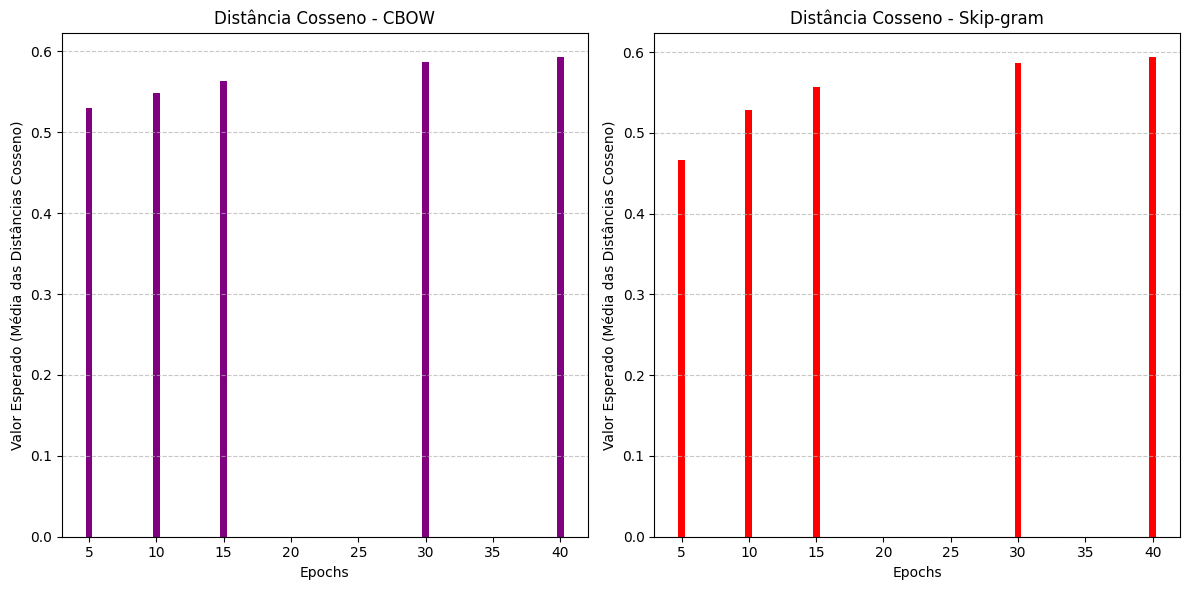

In [41]:
epochs, cbow_expected, skipgram_expected = calculate_average_distances(results, "epochs")
plot_param_size_vs_distance(epochs, "Epochs", cbow_expected, skipgram_expected)

O número de épocas acompanha levemente o valor esperado da distância de cosseno. Isso ocorre porque, ao aumentar o número de épocas, o modelo tem mais oportunidades de ajustar os pesos e aprender padrões mais complexos. No entanto, é importante ressaltar que, em algum momento, ele pode começar a memorizar os dados de treinamento, em vez de generalizar bem para aqueles ainda não vistos. Isso pode levar a um aumento da distância de cosseno, devido a falta da capacidade de capturar bem a semântica das palavras.